## Mervyn Chan 2019 Feb 13th
# This page shows the results of k-fold cross validation analysis for a network trained on 1824 magnetorotational supernova waveforms from 
   
   https://zenodo.org/record/201145#.XGNwkXUzbCL
      

## Data 

### 1. 20000 samples of whitened time series where 10944 (each waveform repeat 6 times with different noise realisations) samples contained signals + noise, and the rest only noise.

## Procedure 

### 1. 2000 random samples out of 20000 samples were drawn as validation data set, which the network never got to see during training.
### 2. the rest 18000 samples then went through a 10-fold cross validation analysis where 10% of the samples took turn to be the test dataset.
### 3. during the training process, the network was trained on training data and validated on validation data and tested against test data.
### 4. For each optimal SNR value from 1 - 10, the above was repeated. 
### 5. At the end, for each SNR, the network was trained 10 times. So in total, the network was trained 100 times and tested against 100 times. 


## Results (There is also a title for each of the plots below)

### The results are shown using a number of plots below, in the following order:

### 1. Plots of true alarm probability given different values of false alarm rate as a function of SNRs, using the model with the least test loss out of 10 trainings for each SNR.
### 2. ROC curves of the network for different SNRs. As for each SNR, the k-fold cross analysis will have 10 different results, only the model with the least test loss is employed.
### 3. Plots of loss / validation loss; accuracy / validation accuracy for SNR from 1 - 3, only a curve for each SNR is shown for simplicity. 
### 4. Plots of loss / validation loss; accuracy / validation accuracy for SNR from 4 - 7. 
### 5. Plots of loss / validation loss; accuracy / validation accuracy for SNR from 8 - 10. 


## Discussion

### Applying the same network from Jan-31-2019-displayofresults.ipynb resulted in seriously overfitting.
### This was a little bit surprising as that network was fitted well to 20000 samples containing only 500 different signals at SNR = 8, 9, 10. 
### So moving from 500 signals to 1824 different signals, I was expecting underfitting. However, it was exactly the other way around.
### So after including all 1824 waveforms, I have tuned the model by basically reducing the number of trainable parameters.
### This reduced the validation loss to the current level while maintaining the test/validation accuracy. 
### I will now move to including magnetorotational waveforms from other authors and neutrino mechanism waveforms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate, signal, optimize, stats
import pickle
from sklearn import metrics

np.set_printoptions(edgeitems=30, linewidth=160)

In [3]:
#load the data
with open("1824waveformSNR110.pkl") as f:
    tscores, history, signal_preds, test_label_saver_for_ROC = pickle.load(f)

# 1. Plots of true alarm probability given different values of false alarm rate as a function of SNRs, using the model with the least test loss out of 10 trainings for each SNR.

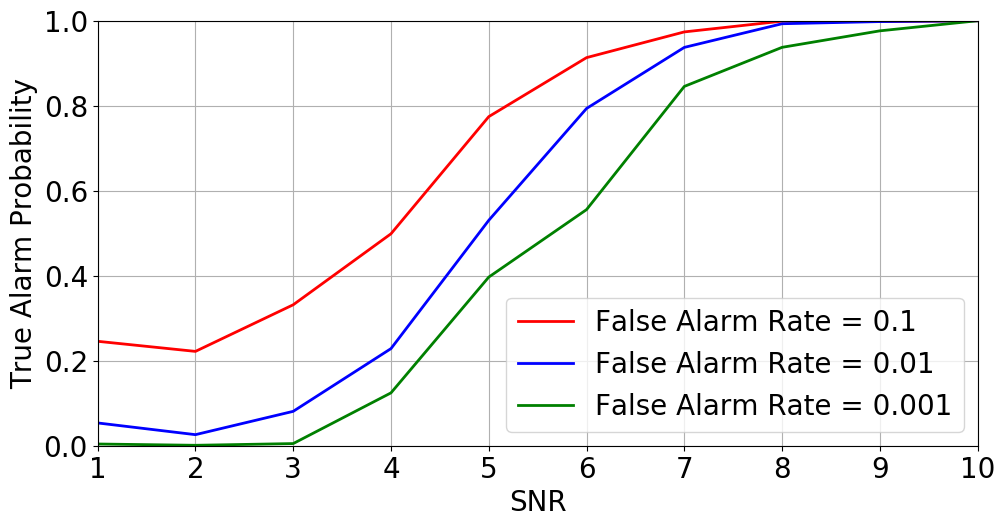

In [36]:
fig = plt.figure(figsize=(11,5), dpi= 100, facecolor='w', edgecolor='k')

t_scores = np.array([np.zeros((10, 2)) for i in range(len(tscores))])
for i in range(len(tscores)):
    for j in range(10):
        t_scores[i][j][0] = tscores[i][j][0]
        t_scores[i][j][1] = tscores[i][j][1]
given_FAR = 0.1;
given_FAR2 = 0.01;
given_FAR3 = 0.001;

SNRs = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
ta_interp_01 = np.zeros(len(SNRs))
ta_interp_001 = np.zeros(len(SNRs))
ta_interp_0001 = np.zeros(len(SNRs))
mark_best = []
for i in range(len(SNRs)):  
    fa, ta = plot_roc(test_label_saver_for_ROC[i], signal_preds[i], SNRs[i], False)
    j = np.argmin(t_scores[i][:,0])     
    mark_best.append(j)
    ta_interp_01[i] = interpta(fa[j], ta[j], given_FAR)
    ta_interp_001[i] = interpta(fa[j], ta[j], given_FAR2)
    ta_interp_0001[i] = interpta(fa[j], ta[j], given_FAR3)
plt.plot(SNRs, ta_interp_01, linewidth = 2.0, color = 'r', label = 'False Alarm Rate = 0.1')
plt.plot(SNRs, ta_interp_001, linewidth = 2.0, color = 'b', label = 'False Alarm Rate = 0.01')
plt.plot(SNRs, ta_interp_0001, linewidth = 2.0, color = 'g', label = 'False Alarm Rate = 0.001')
plt.grid()
ax = plt.gca()
plt.xlim([1, 10])
plt.ylim([0, 1])
plt.legend(loc = 4, fontsize =20)
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.90, top = 0.95)
plt.xlabel('SNR', fontsize =20)
plt.ylabel('True Alarm Probability', fontsize =20)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
plt.show()


# 2. ROC curves of the network for different SNRs. As for each SNR, the k-fold cross analysis will have 10 different results, only the model with the least test loss is employed.

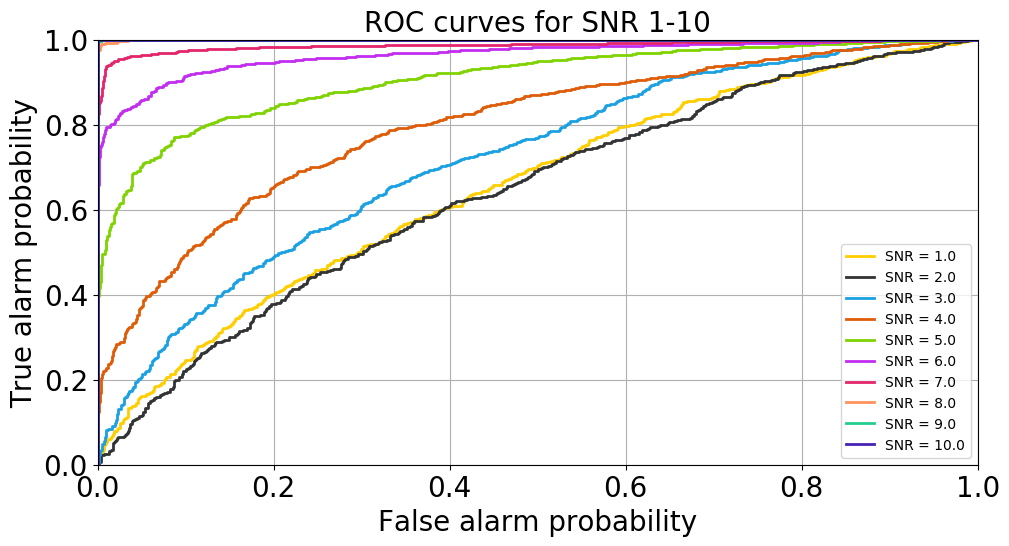

In [31]:
fig = plt.figure(figsize=(11,5), dpi= 100, facecolor='w', edgecolor='k')

for i in range(len(SNRs)): 
    tem_fa, tem_ta, _ = metrics.roc_curve(test_label_saver_for_ROC[i][mark_best[i]][:,1], signal_preds[i][mark_best[i]][:,1])
    plt.plot(tem_fa, tem_ta, linewidth = 2, color = color_shelf(SNRs[i]) , label = 'SNR = %s' %(SNRs[i]))
    plt.xlabel('False alarm probability',fontsize = fontsize)
    plt.ylabel('True alarm probability',fontsize = fontsize)
    plt.title('ROC curves for SNR 1-10', fontsize = fontsize)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.90, top = 0.95)
plt.grid()
plt.legend()
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
plt.show()

In [17]:
def color_shelf(SNR):
    nf = 255.0
    RGB_choice = {
        1 : [255.0, 206.0, 0.0],
        2 : [49.0, 51.0, 53.0],
        3 : [27.0, 161.0, 226.0],
        4 : [222.0, 93.0, 9.0],
        5 : [128.0, 211.0, 2.0],
        6 : [194.0, 45.0, 240.0],
        7 : [227.0, 37.0, 107.0],
        8 : [255.0, 146.0, 93.0],
        9 : [33.0, 206.0, 142.0],
        10: [70.0, 33.0, 180.0]
    }
    #RGB[SNR]
    RGB = [x /nf for x in RGB_choice[SNR]]
    return RGB


In [59]:
def plotlossacc_together(history, fontsize, SNR, Loss_top, Loss_bottom, Acc_top, Acc_bottom):
    fig , axs = plt.subplots(2,1, sharex = True, figsize=(22,11), dpi= 100, facecolor='w', edgecolor='k')
    axs = axs.ravel()
    # plot history
    #fig = plt.figure()

    for history_10 in history:
        counter = 0
        for history_i in history_10[0:1]:
            if counter == 0:
                axs[0].plot(np.arange(epochs) + 1, history_i.history['loss'], label = 'Loss at SNR = %s' %(SNR), linewidth = 2, linestyle ='dashdot', color = color_shelf(SNR))
                axs[0].plot(np.arange(epochs) + 1, history_i.history['val_loss'], label = 'Validation Loss at SNR = %s' %(SNR), linewidth = 2, linestyle ='-', color = color_shelf(SNR))

                axs[1].plot(np.arange(epochs) + 1, history_i.history['acc'], label = 'Accuracy at SNR = %s' %(SNR), linewidth = 2,  linestyle ='dashdot', color =  color_shelf(SNR))
                axs[1].plot(np.arange(epochs) + 1, history_i.history['val_acc'], label = 'Validation Accurarcy at SNR = %s' %(SNR), linewidth = 2, linestyle ='-', color =  color_shelf(SNR))
                # set labels
                axs[0].set_ylabel('Loss', fontsize = fontsize)
                axs[1].set_xlabel('Epoch', fontsize = fontsize)
                axs[1].set_ylabel('Acc', fontsize = fontsize)



                # legends
                axs[0].legend(fontsize = fontsize - 5, ncol=3)
                axs[1].legend(fontsize = fontsize - 5, ncol=3)
            else:
                axs[0].plot(np.arange(epochs) + 1, history_i.history['loss'], linewidth = 2, linestyle ='dashdot', color = color_shelf(SNR))
                axs[0].plot(np.arange(epochs) + 1, history_i.history['val_loss'], linewidth = 2, linestyle ='-', color = color_shelf(SNR))

                axs[1].plot(np.arange(epochs) + 1, history_i.history['acc'], linewidth = 2, linestyle ='dashdot', color = color_shelf(SNR))
                axs[1].plot(np.arange(epochs) + 1, history_i.history['val_acc'], linewidth = 2, linestyle ='-', color = color_shelf(SNR))
                # set labels
                axs[0].set_ylabel('Loss', fontsize = fontsize)
                axs[1].set_xlabel('Epoch', fontsize = fontsize)
                axs[1].set_ylabel('Acc', fontsize = fontsize)



                # legends
                #axs[0].legend(fontsize = fontsize - 5)
                #axs[1].legend(fontsize = fontsize - 5)
            counter += 1
        SNR +=1    
    # grids
    axs[0].grid()
    axs[1].grid()
    axs[0].set_xlim([1, epochs])
    axs[0].set_ylim(top = Loss_top, bottom = Loss_bottom)
    axs[0].set_xticks(np.arange(epochs) +1)
    axs[1].set_xlim([1, epochs])
    axs[1].set_ylim(top = Acc_top, bottom = Acc_bottom)
    axs[1].set_xticks(np.arange(epochs) +1)
    plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.90, top = 0.95)
    for ax in axs:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('normal')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('normal')
    plt.show()


# 3. plots of loss / validation loss; accuracy / validation accuracy for SNR from 1 - 3, only a curve for each SNR is shown for simplicity. 

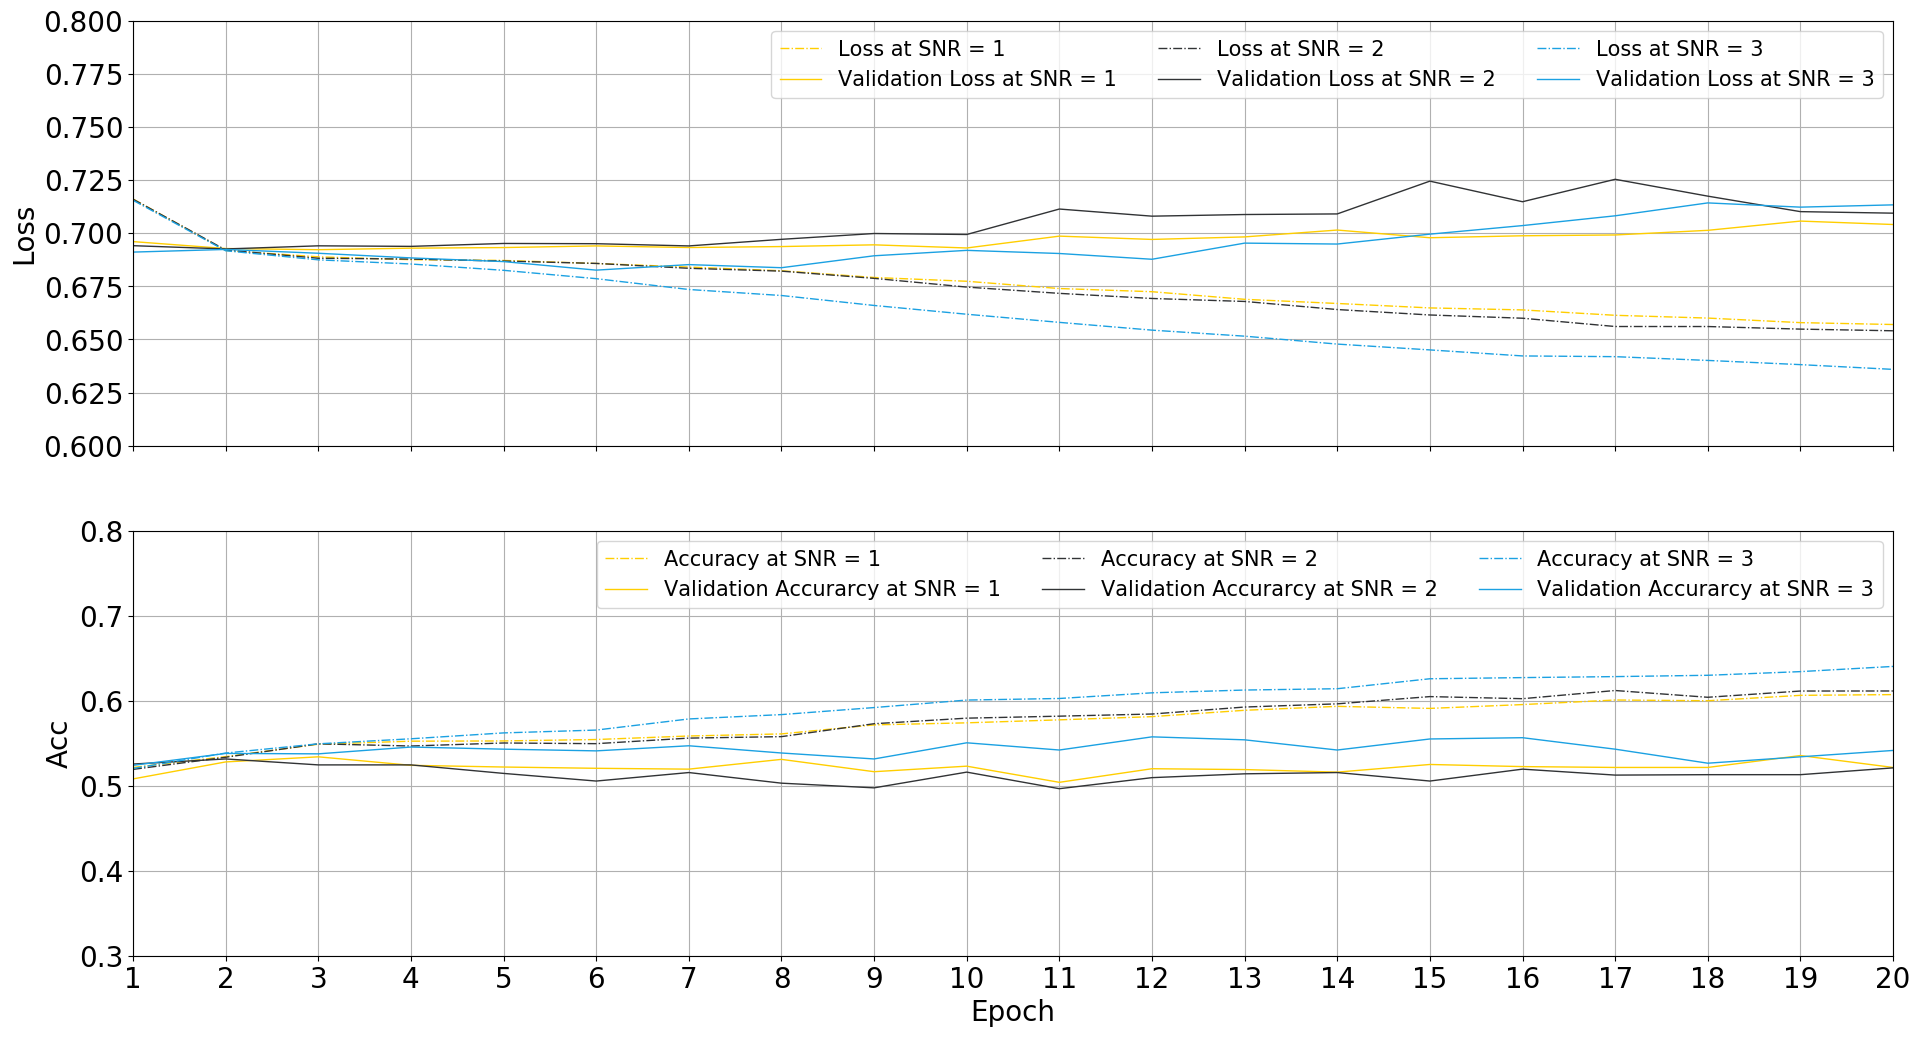

In [53]:
fontsize = 20
epochs = 20
Loss_top = 0.8
Loss_bottom = 0.6
Acc_top = 0.8
Acc_bottom = 0.3
plotlossacc_together(history[0:3], fontsize, 1, Loss_top, Loss_bottom, Acc_top, Acc_bottom)

# 4. plots of loss / validation loss; accuracy / validation accuracy for SNR from 4 - 7. 

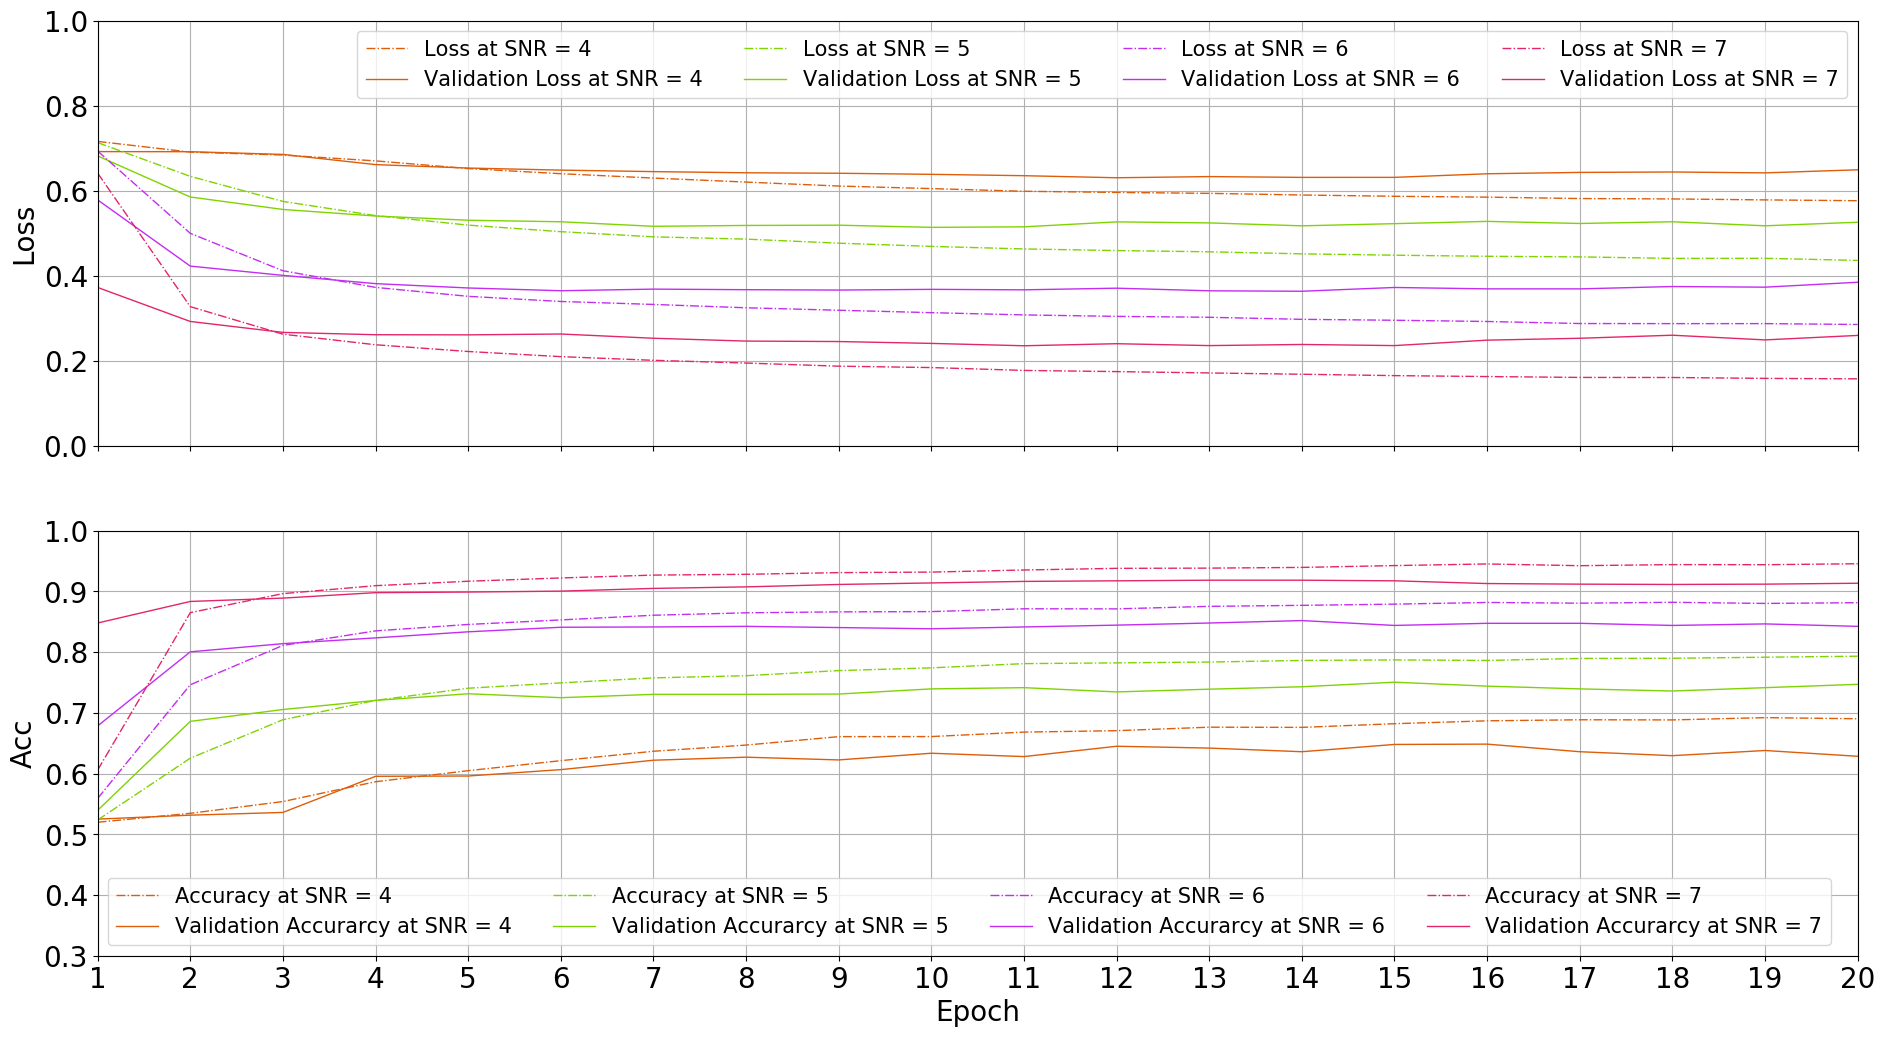

In [56]:
fontsize = 20
Loss_top = 1.0
Loss_bottom = 0.0
Acc_top = 1.0
Acc_bottom = 0.3
plotlossacc_together(history[3:7], fontsize, 4, Loss_top, Loss_bottom, Acc_top, Acc_bottom)

# 5. plots of loss / validation loss; accuracy / validation accuracy for SNR from 8 - 10. 

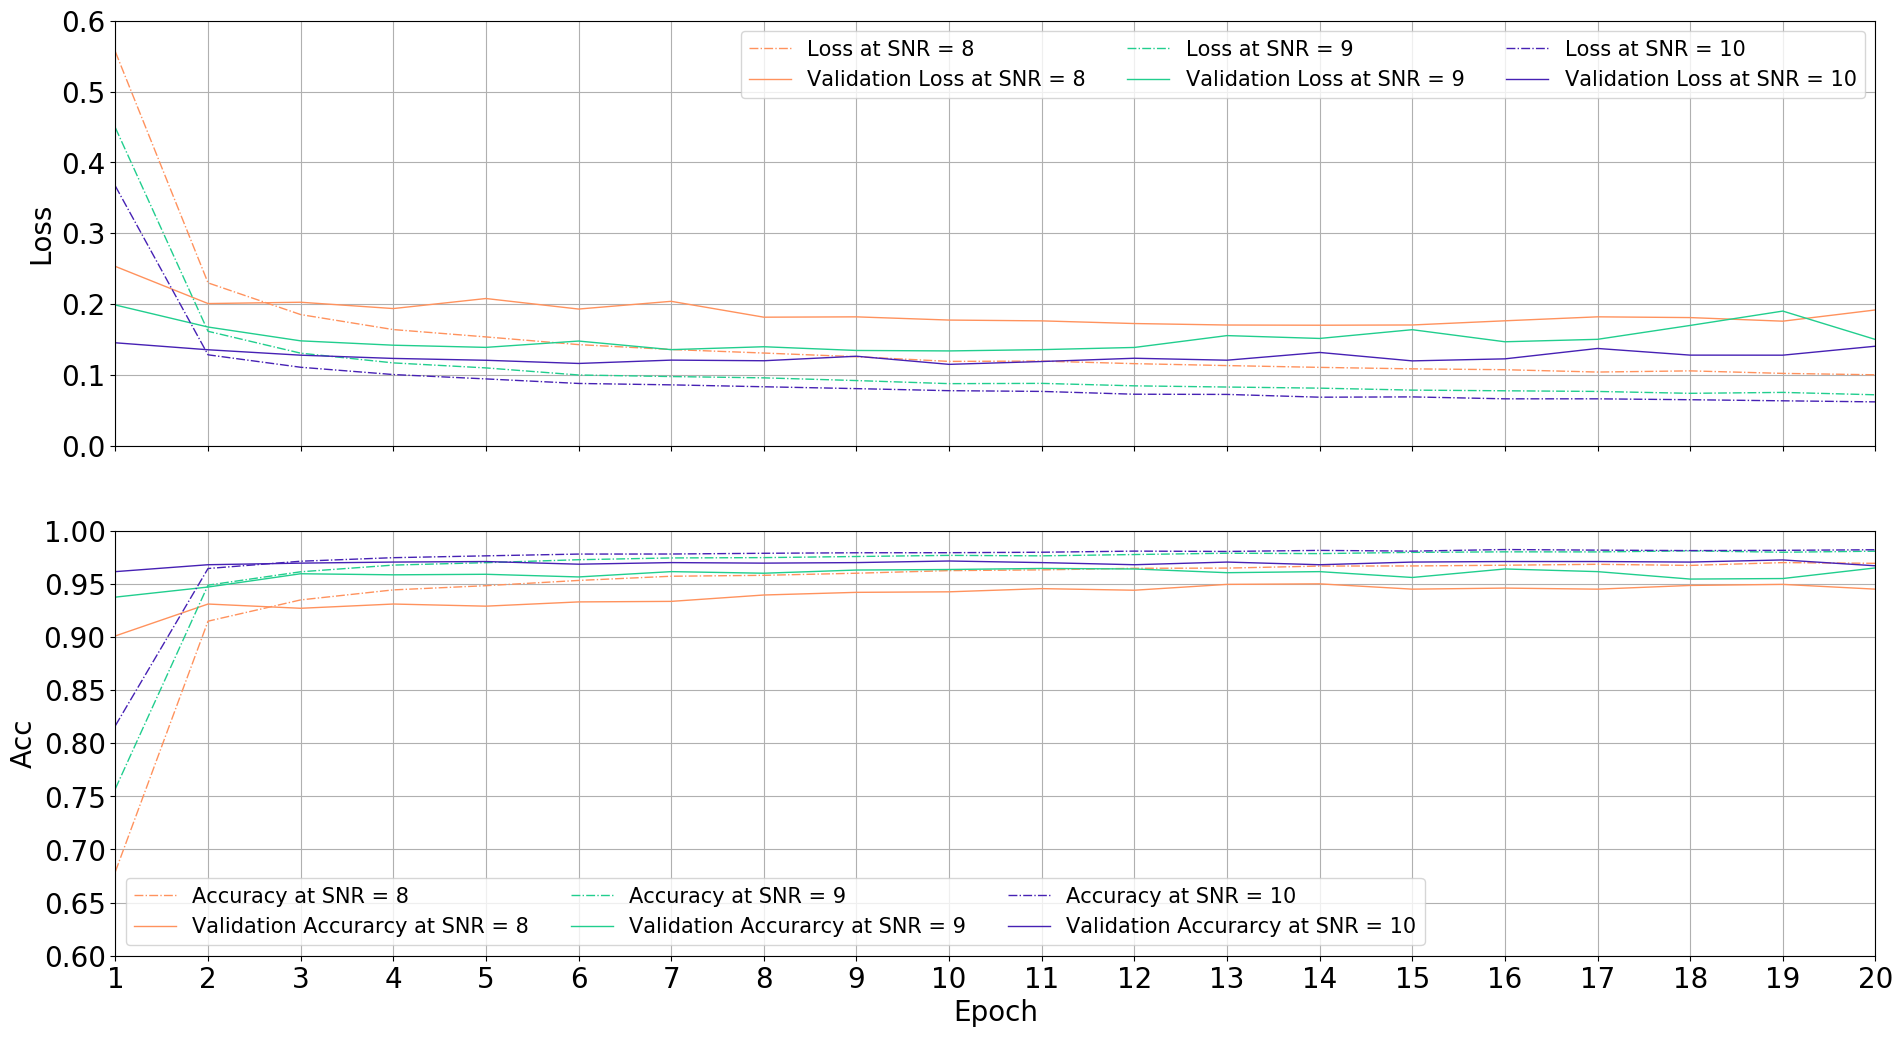

In [58]:
fontsize = 20
#history = history_saver[0][0]
Loss_top = 0.6
Loss_bottom = 0.0
Acc_top = 1.0
Acc_bottom = 0.6
plotlossacc_together(history[7:], fontsize, 8, Loss_top, Loss_bottom, Acc_top, Acc_bottom)

In [21]:
def plot_roc(test_label, signal_preds, SNR, plot):
    if plot == True:
        fig = plt.figure()
    fa = []#[[] for i in range(len(test_label))]
    ta = []#[[] for i in range(len(test_label))]
    for i, j in zip(test_label, signal_preds):
        tem_fa, tem_ta, _ = metrics.roc_curve(i[:,1], j[:,1])
        fa.append(tem_fa)
        ta.append(tem_ta)
        if plot == True:
            plt.plot(tem_fa, tem_ta, linewidth = 2, color = 'b')
            plt.xlabel('False alarm probability',fontsize = fontsize)
            plt.ylabel('True alarm probability',fontsize = fontsize)
            plt.title('ROC curve for SNR %s'%(SNR), fontsize = fontsize)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.90, top = 0.95)
            
             
    if plot == True:            
        plt.grid()
        ax = plt.gca()
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('normal')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('normal')
        plt.show()
    return fa, ta


def interpta(fa, ta, given_FAP):
     
    ta_fun = interpolate.interp1d(fa, ta)
    
    ta_interp = ta_fun(given_FAP)
    
    return ta_interp